In [397]:
import numpy as np
from FastCCM import CCM, CCM_utils
from FastCCM.utils import get_td_embeddings
from manifold_learning.utils import utils
from manifold_learning.data.data_loader import get_truncated_lorenz_rand
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from manifold_learning import imd_nd_smap,imd_1d_smap
import importlib
importlib.reload(imd_1d_smap)
importlib.reload(imd_nd_smap)
importlib.reload(CCM)

<module 'FastCCM.CCM' from '/home/iaroslav/Documents/Python projects/FastCCM/src/FastCCM/CCM.py'>

In [398]:
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y,axis=1)**2 / (2 * sigma**2))

In [399]:
X = get_truncated_lorenz_rand(400,n_steps=20000,)

observables = StandardScaler().fit_transform(X)

In [400]:
exp_kernel_grid = np.array(np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),10), np.linspace(X[:,2].min(),X[:,2].max(),10))).reshape(2,-1).T

In [607]:
X_ = [get_truncated_lorenz_rand(400,n_steps=20000)[:,[0,2]] for i in range(1)]
observables = np.concatenate([np.array([gaussian_kernel(x,e,sigma=6) for e in exp_kernel_grid]) for x in X_]).T
observables[observables < 0.1] = 0
#observables = StandardScaler().fit_transform(observables)

In [608]:
eps = np.random.uniform(0,1,size=observables.shape)
eps = ((eps/eps.std(axis=0)) * observables.std(axis=0) * 1)
observables += eps

In [17]:
mixing_mat = np.random.normal(size=(observables.shape[1],observables.shape[1]))
observables = observables @ mixing_mat
observables = StandardScaler().fit_transform(observables)


In [7]:

observables = utils.get_td_embedding_np(observables,3,5).reshape(-1,3*observables.shape[1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


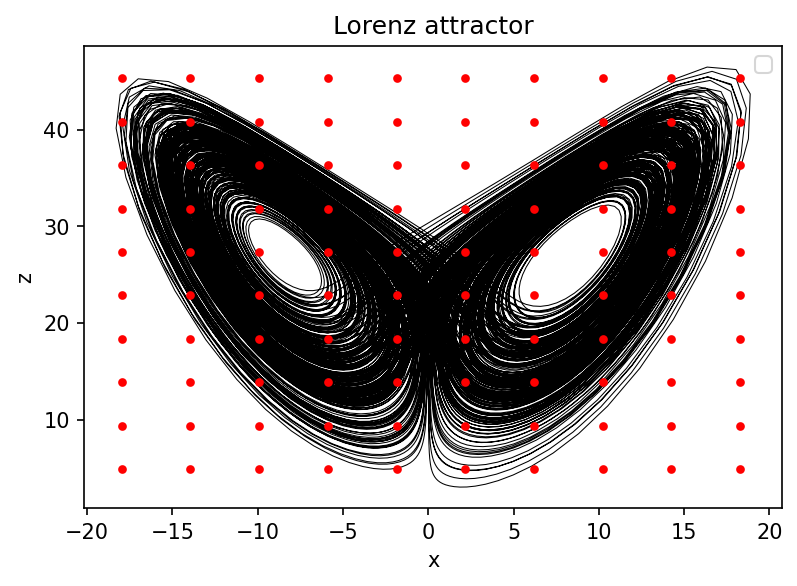

In [410]:
plt.figure(figsize=(6,4),dpi=150)
plt.plot(X_[0][:,0],X_[0][:,1],color="black",lw=0.5)
plt.scatter(*exp_kernel_grid.T,color="red",zorder=100,s=10)
plt.xlabel("x")
plt.ylabel("z")
plt.title("Lorenz attractor")
plt.legend()

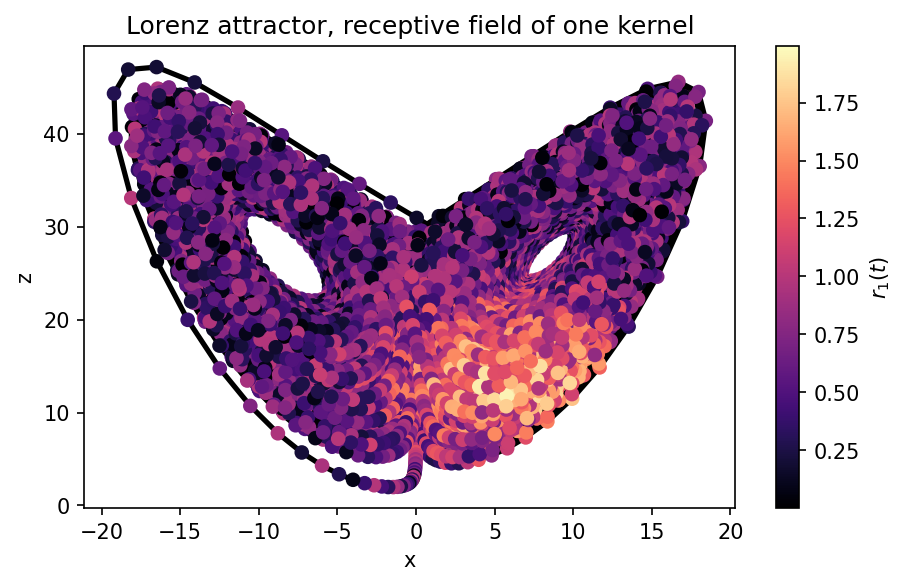

In [609]:
plt.figure(figsize=(7,4),dpi=150)
plt.plot(X_[0][:,0],X_[0][:,1],color="black",lw=2.5)
plt.scatter(X_[0][:,0],X_[0][:,1],c=observables[:,26],zorder=100,cmap="magma")
plt.xlabel("x")
plt.ylabel("z")
plt.title("Lorenz attractor, receptive field of one kernel")
plt.colorbar(label="$r_{1}(t)$")

Text(0, 0.5, 'Kernel value (${r_{1}(t)}$)')

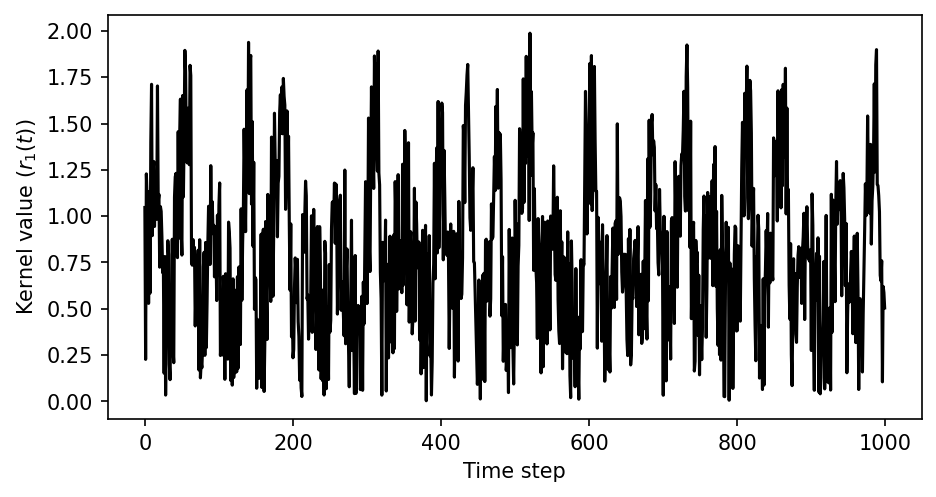

In [610]:
plt.figure(figsize=(7,3.5),dpi=150)
plt.plot(observables[:1000,23],color="black")

plt.xlabel("Time step")
plt.ylabel("Kernel value (${r_{1}(t)}$)")

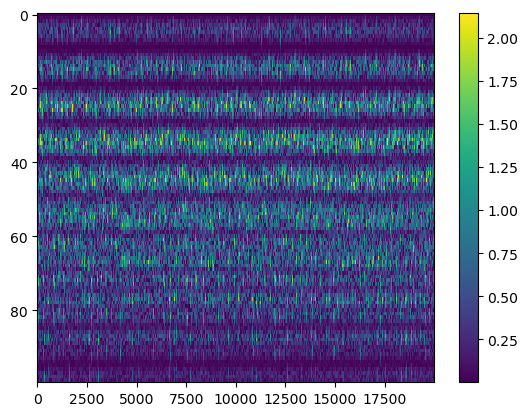

In [611]:
plt.imshow(observables.T,aspect="auto",interpolation="nearest")
plt.colorbar()

In [693]:
trainer = imd_nd_smap.IMD_nD_smap(observables.shape[1], embed_dim=10, n_components=1, subtract_corr=False, device="cuda")


In [366]:
trainer = imd_1d_smap.IMD_1D_smap(observables.shape[1], embed_dim=2, embed_lag=7, n_components=1, subtract_corr=False, device="cuda")


In [702]:
trainer.fit(observables, sample_len=150, library_len=800, 
            exclusion_rad=30, theta=5, tp=30, 
            epochs=1000, num_batches=32,optimizer="Adagrad", learning_rate=0.01, tp_policy="range",loss_mask_size=None)
            


Epoch 1/1000, Loss: 0.2099
Epoch 2/1000, Loss: 0.2035
Epoch 3/1000, Loss: 0.2050
Epoch 4/1000, Loss: 0.2043
Epoch 5/1000, Loss: 0.2026
Epoch 6/1000, Loss: 0.2009
Epoch 7/1000, Loss: 0.2057
Epoch 8/1000, Loss: 0.2073
Epoch 9/1000, Loss: 0.2052
Epoch 10/1000, Loss: 0.2066
Epoch 11/1000, Loss: 0.2075
Epoch 12/1000, Loss: 0.2058
Epoch 13/1000, Loss: 0.2029
Epoch 14/1000, Loss: 0.2025
Epoch 15/1000, Loss: 0.2046
Epoch 16/1000, Loss: 0.2018
Epoch 17/1000, Loss: 0.2054
Epoch 18/1000, Loss: 0.2033
Epoch 19/1000, Loss: 0.2123
Epoch 20/1000, Loss: 0.2111
Epoch 21/1000, Loss: 0.2119
Epoch 22/1000, Loss: 0.2102
Epoch 23/1000, Loss: 0.2108
Epoch 24/1000, Loss: 0.2049
Epoch 25/1000, Loss: 0.2018
Epoch 26/1000, Loss: 0.2139
Epoch 27/1000, Loss: 0.2092
Epoch 28/1000, Loss: 0.2062
Epoch 29/1000, Loss: 0.2086
Epoch 30/1000, Loss: 0.2020
Epoch 31/1000, Loss: 0.2027
Epoch 32/1000, Loss: 0.2047
Epoch 33/1000, Loss: 0.1982
Epoch 34/1000, Loss: 0.2018
Epoch 35/1000, Loss: 0.2012
Epoch 36/1000, Loss: 0.2046
E

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

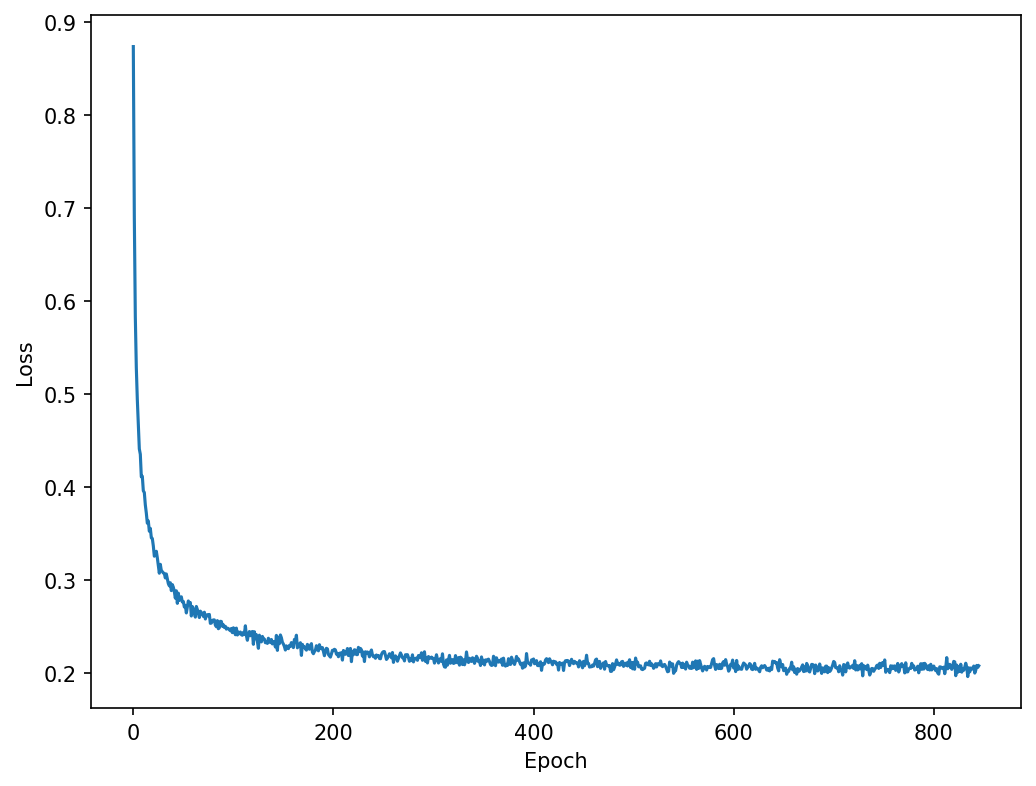

In [703]:
plt.figure(figsize=(8,6),dpi=150)
plt.plot(trainer.get_loss_history()[:])
plt.xlabel("Epoch")
plt.ylabel("Loss")


In [704]:

unmixed = trainer.predict(observables)

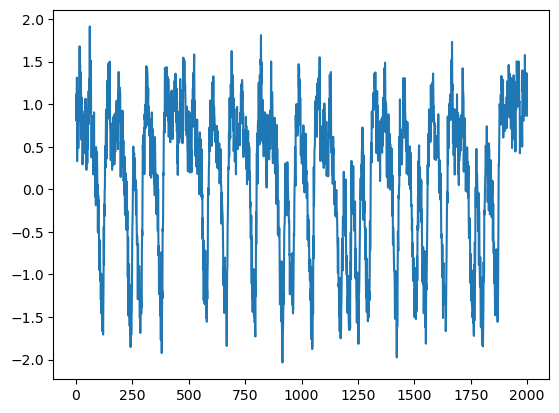

In [716]:

plt.plot(unmixed[:2000,0,9])

Text(0.5, 1.0, 'Reconstructed attractor')

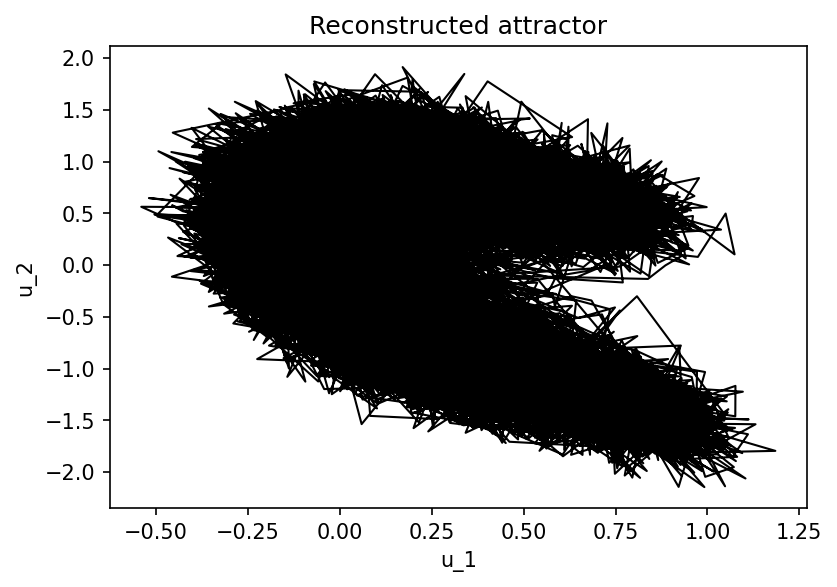

In [717]:
plt.figure(figsize=(6,4),dpi=150)
plt.plot(unmixed[:,0,0],unmixed[:,0,1],lw=1,color="black")
plt.xlabel("u_1")
plt.ylabel("u_2")
plt.title("Reconstructed attractor")

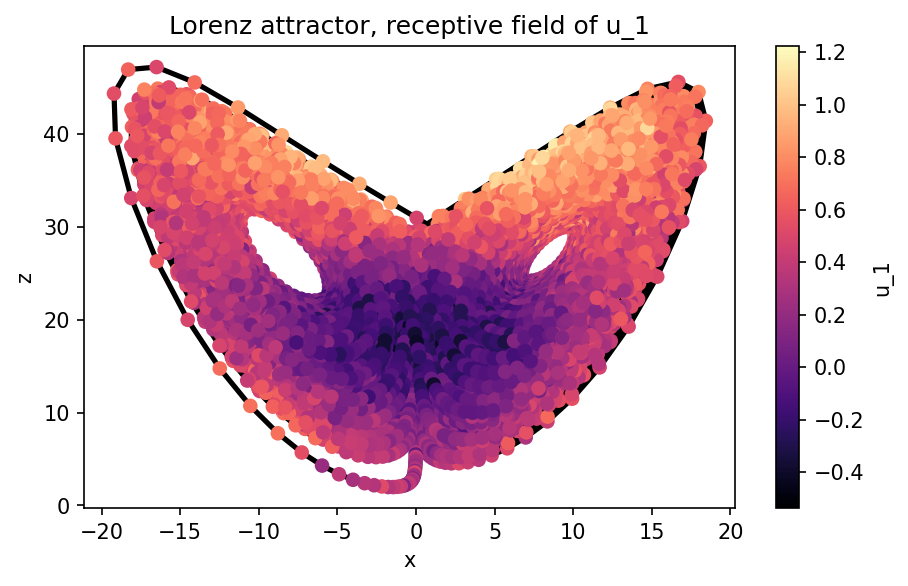

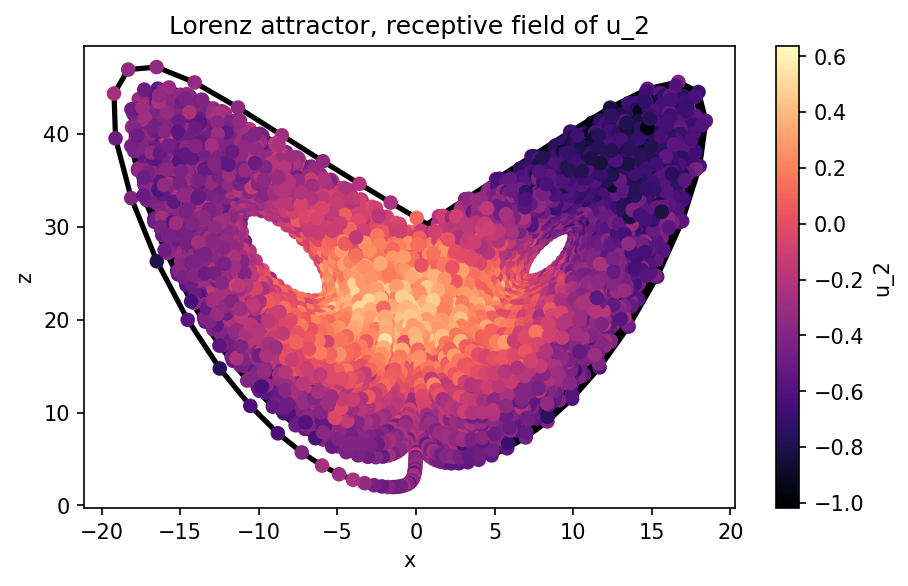

In [699]:
plt.figure(figsize=(7,4),dpi=150)
plt.plot(X_[0][:,0],X_[0][:,1],color="black",lw=2.5)
plt.scatter(X_[0][:,0],X_[0][:,1],c=unmixed[:,0,0],zorder=100,cmap="magma")
plt.xlabel("x")
plt.ylabel("z")
plt.title("Lorenz attractor, receptive field of u_1")
plt.colorbar(label="u_1")
plt.show()
plt.figure(figsize=(7,4),dpi=150)
plt.plot(X_[0][:,0],X_[0][:,1],color="black",lw=2.5)
plt.scatter(X_[0][:,0],X_[0][:,1],c=unmixed[:,0,1],zorder=100,cmap="magma")
plt.xlabel("x")
plt.ylabel("z")
plt.title("Lorenz attractor, receptive field of u_2")
plt.colorbar(label="u_2")

In [84]:
plt.matshow((trainer.model.get_weights()[:,0])[:,0].reshape(32,32))
plt.matshow((trainer.model.get_weights()[:,0])[:,1].reshape(32,32))

ValueError: cannot reshape array of size 100 into shape (32,32)

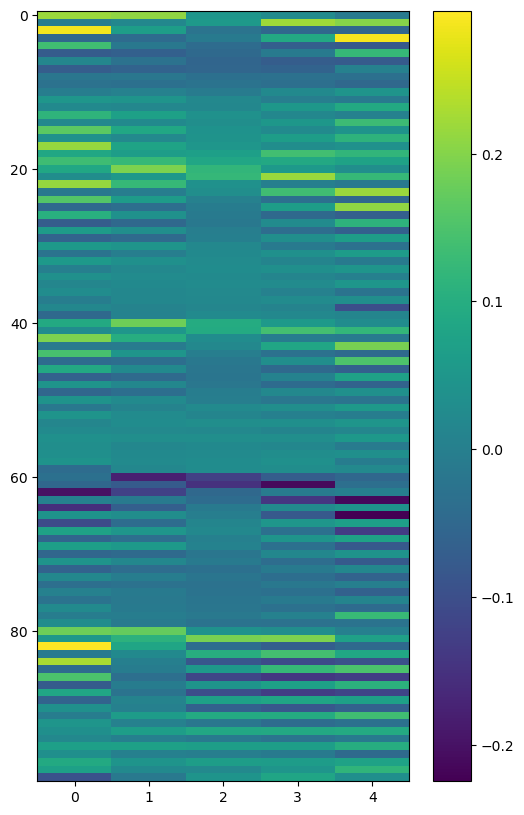

In [631]:

plt.figure(figsize=(6,10))
plt.imshow((trainer.model.get_weights()[:,0]),aspect="auto",interpolation="nearest")
plt.colorbar()

In [598]:
obs_mask = observables.mean(axis=0) > 0.01
observables_filtered = observables[:,obs_mask]

In [580]:
opt_E_list = []
opt_tau_list = []
for i in range(observables_filtered.shape[1]):

    temp_res = CCM_utils.Functions("cpu").find_optimal_embedding_params(observables_filtered[:,i],observables_filtered[:,i],
                                                        subset_size=700,subsample_size=150,exclusion_rad=30,
                                                        E_range=np.arange(1,10),tau_range=np.arange(1,20),tp_max=20,method="simplex",nbrs_num=10)
    opt_E_list += [temp_res["optimal_E"]]
    opt_tau_list += [temp_res["optimal_tau"]]

In [689]:
observables_emb = get_td_embeddings(observables_filtered.T,opt_E_list,opt_tau_list)

In [706]:
pred_interval_unmixed = []
for i in range(10):
    pred_interval_res = CCM_utils.Functions("cuda").prediction_interval_test(unmixed[:,0], X_[0][:,[0]],subsample_size=250, subset_size=800,max_tp=100,
                exclusion_rad=30, method="smap",theta=5,)

    pred_interval_unmixed += [pred_interval_res["X_to_Y"].mean(axis=0)[:,0]]
pred_interval_unmixed = np.array(pred_interval_unmixed).mean(axis=0)

In [685]:
pred_interval_source = []
for i in range(10):
    pred_interval_res = CCM_utils.Functions("cuda").prediction_interval_test(
        utils.get_td_embedding_np(X_[0][:,[0]],2,5)[:,:,0], 
        X_[0][:,[0]],subsample_size=250, subset_size=800,max_tp=100,
                exclusion_rad=30, method="smap",theta=5,)

    pred_interval_source += [pred_interval_res["X_to_Y"].mean(axis=0)[:,0]]
pred_interval_source = np.array(pred_interval_source).mean(axis=0)

In [690]:
pred_interval_obs_list = []
for j in range(observables_filtered.shape[1]):
    pred_interval_obs = []
    for i in range(10):
        pred_interval_obs_res = CCM_utils.Functions("cuda").prediction_interval_test(observables_emb[j], X_[0],subsample_size=250, subset_size=800,max_tp=100,
                exclusion_rad=30, method="smap",theta=5,)

        pred_interval_obs += [pred_interval_obs_res["X_to_Y"].mean(axis=0)[:,0]]
    pred_interval_obs = np.array(pred_interval_obs).mean(axis=0)
    pred_interval_obs_list += [pred_interval_obs]


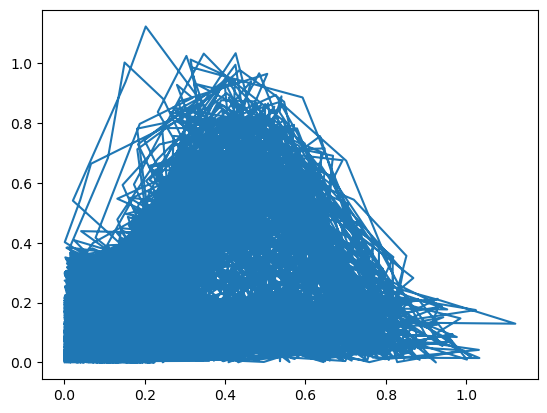

In [673]:
plt.plot(observables_emb[26][:,0],observables_emb[26][:,1])

Text(0.5, 1.0, 'Prediction accuracy of x-axis of Lorenz system using different embeddings\ngiven observables with additive noise')

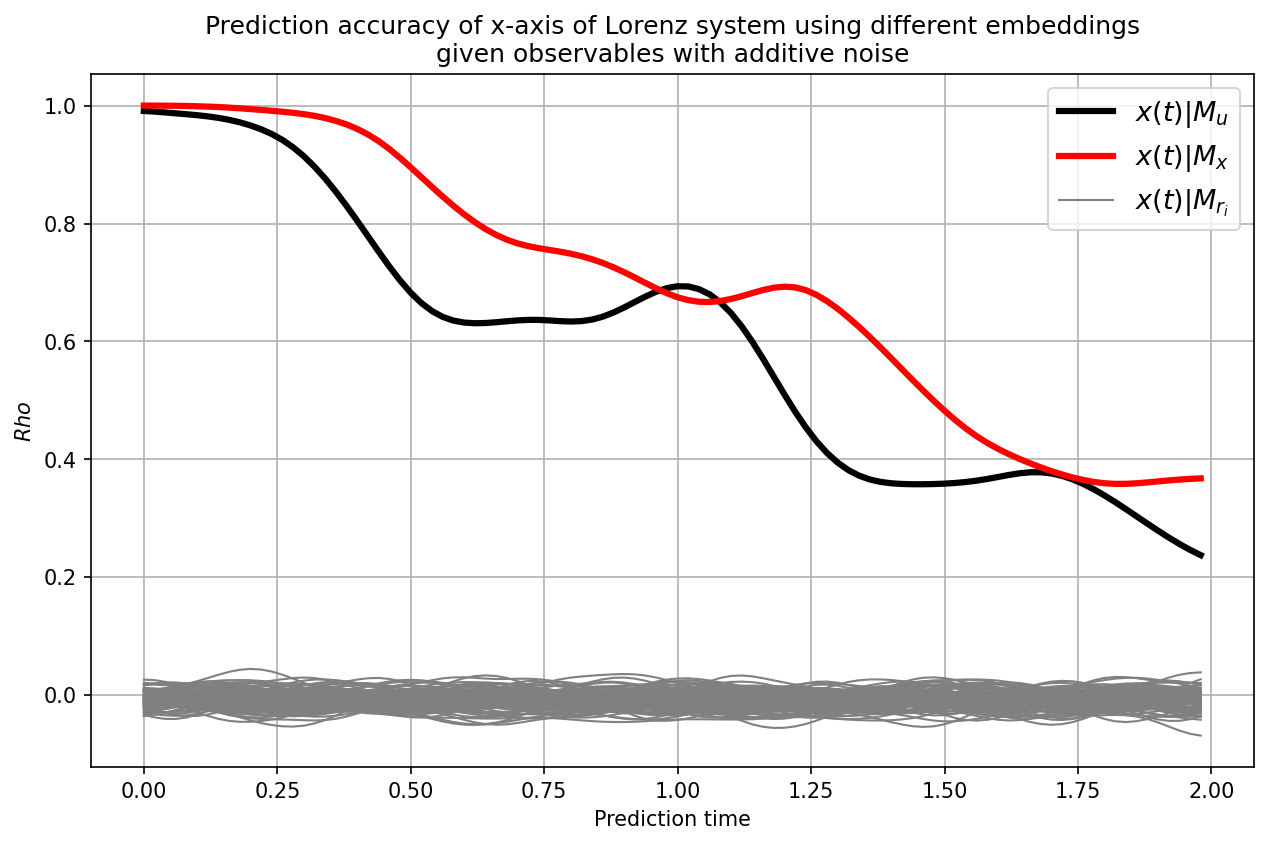

In [707]:
plt.figure(figsize=(10,6),dpi=150)
plt.plot(np.arange(100)*400/20000,pred_interval_unmixed,color="black",lw=3,label="$x(t)|M_u$",zorder=5)
plt.plot(np.arange(100)*400/20000,pred_interval_source,color="red",lw=3,zorder=10)
plt.plot(np.arange(100)*400/20000,np.array(pred_interval_obs_list).T,color="gray",lw=1)
plt.legend(labels=["$x(t)|M_u$", "$x(t)|M_x$","$x(t)|M_{r_i}$", ],fontsize=13)
plt.grid()
plt.xlabel("Prediction time")
plt.ylabel("$Rho$")
plt.title("Prediction accuracy of x-axis of Lorenz system using different embeddings\n"
          "given observables with additive noise")